
# Clustering e Regressão Linear


- Contexto: O dataset "Boston House Pricing" é um famoso dataset utilizado para construir modelos de regressão linear. Neste notebook, apresentaremos uma alternativa para criação destes modelos através de uma etapa prévia de clusterização e a posterior criação de modelos de regressão por cluster, a fim de prever a variável target MEDV
- Link para o dataset original: https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data/data
- Alunos:
  - Angelo Carmignani
  - Juan Freire Dantas Galvão
  - Vitória Karoline de Lacerda Guedes da Silva

Attribute Information
Input features in order:
- 1) CRIM: per capita crime rate by town
- 2) ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
- 3) INDUS: proportion of non-retail business acres per town
- 4) CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- 5) NOX: nitric oxides concentration (parts per 10 million) [parts/10M]
- 6) RM: average number of rooms per dwelling
- 7) AGE: proportion of owner-occupied units built prior to 1940
- 8) DIS: weighted distances to five Boston employment centres
- 9) RAD: index of accessibility to radial highways
- 10) TAX: full-value property-tax rate per $10,000 [$/10k]
- 11) PTRATIO: pupil-teacher ratio by town
- 12) B: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- 13) LSTAT: % lower status of the population

Output variable:
- 1) MEDV: Median value of owner-occupied homes in $1000's [k$]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import silhouette_score

In [3]:
df = pd.read_csv("boston_2.csv")
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


- O objetivo inicialmente é clusterizar os dados para depois desenvolver um modelo de regressão por cluster.

In [4]:
df.isna().sum() #Não há valores ausentes

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## Clustering

### KMeans

Em um primeiro momento, aplicaremos o KMeans. Como é um algoritmo baseado na distância vetorial entre os registros, e define centróides a partir de médias, acaba sendo muito sensível a outliers. Por isso, ao usar o KMeans, é especialmente importante lidar com outliers.

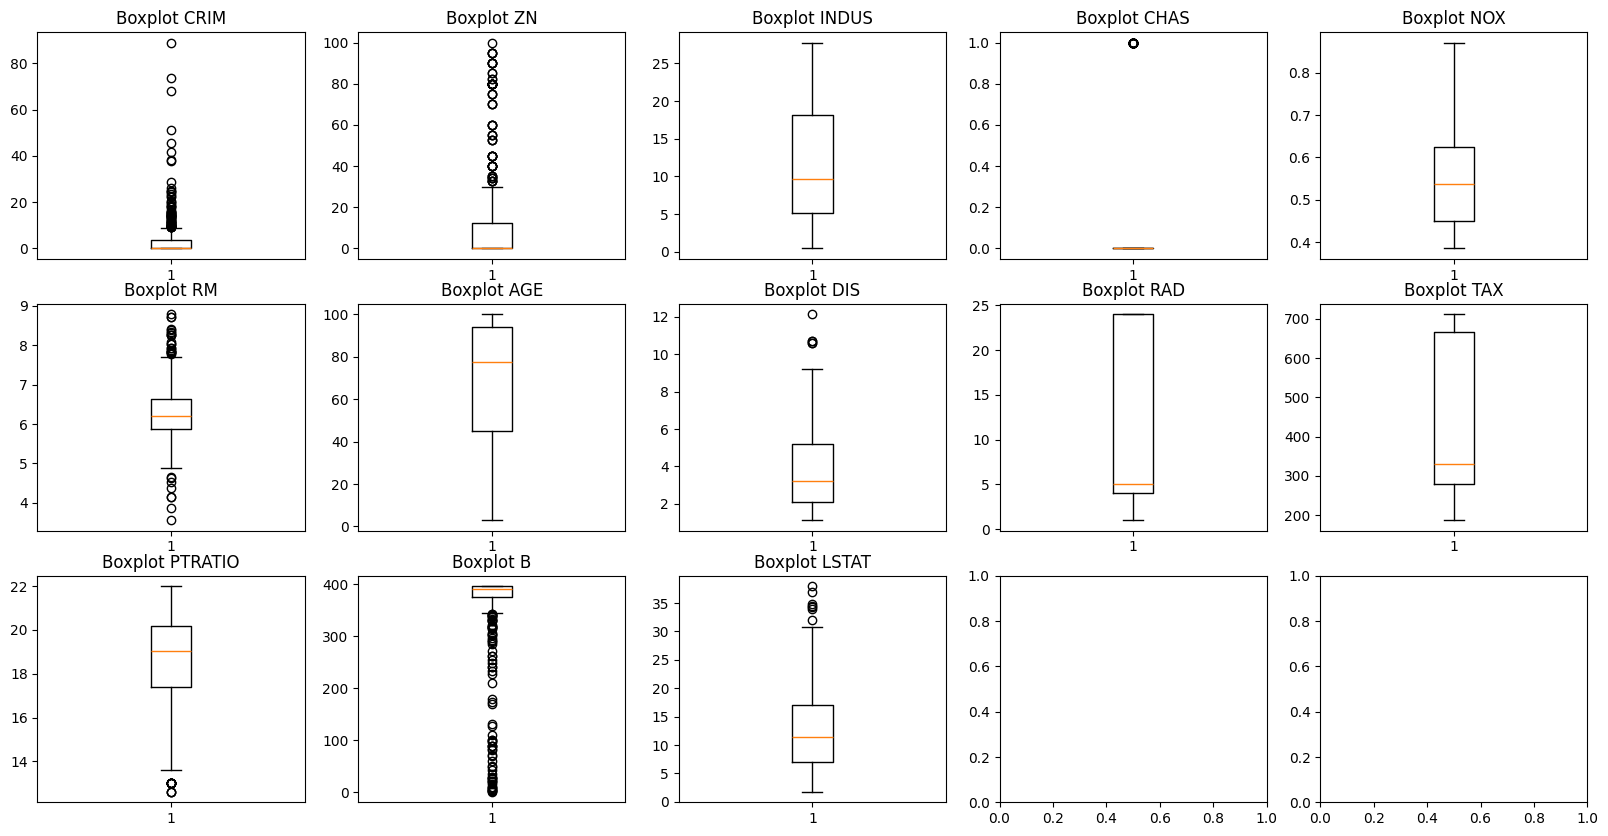

In [5]:
#Verificando outliers nas features

x = df.drop(columns = "MEDV")

fig, ax = plt.subplots(ncols=5,nrows=3,figsize = (20,10))

for index, col in enumerate(x.columns):
    row, col_idx = divmod(index, 5)  # Converte índice linear para matriz 2D
    ax[row, col_idx].boxplot(df[col])
    ax[row, col_idx].set_title(f"Boxplot {col}")

plt.show()



In [6]:
def remove_outlier(x):

  df_no = x.copy()
  for col in x.columns:

    q1 = x[col].quantile(0.25)
    q3 = x[col].quantile(0.75)

    iqr = q3 - q1

    lim_inf = q1 - 1.5*iqr
    lim_sup = q3 + 1.5*iqr

    df_no = df_no[(df_no[col]>=lim_inf) & (df_no[col]<=lim_sup)]

  return df_no

df_no = remove_outlier(x)

print(1-len(df_no)/len(x))

0.45849802371541504


- Remover os outliers tirou 45% dos dados, então ao invés de remover vamos substituir os outliers pela mediana da coluna.

In [10]:
def replace_median(x):

  df_no = x.copy()
  for col in x.columns:

    q1 = x[col].quantile(0.25)
    q3 = x[col].quantile(0.75)

    iqr = q3 - q1

    lim_inf = q1 - 1.5*iqr
    lim_sup = q3 + 1.5*iqr

    median = np.median(x[col])

    df_no[col] = np.where((df_no[col]<lim_inf) | (df_no[col]>lim_sup),median,df_no[col])

  return df_no

df_rm = replace_median(x)

- O algoritmo do KMeans se baseia na distancia entre os pontos de dados, por isso padronizar ou normalizar os dados é muito importante antes de aplicar o algoritmo.
- Utilizamos o StandardScaler, isto é, padronizamos os dados ao inves de normalizá-los. Esta decisão foi tomada em razão das features (X) serem todas uma taxa ou proporção, de forma que não estão em diferentes unidades (situação na qual é comum usar normalização).

In [11]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_rm)
df_scaled = pd.DataFrame(df_scaled, columns = x.columns)

- Feitas as tratativas podemos aplicar o algoritmo. O KMeans exige um input prévio do número de K clusters, para decidir este número K, utilizaremos o gráfico de cotovelo (Elbow).
- Esse método basicamente realiza a clusterização mudando os valores de K, e para cada valor calcula a soma dos erros quadrados dentro de cada cluster (distância de cada ponto do cluster ao centróide do cluster) - WCSS (within cluster sum of squares)
- Teremos então uma relação valor de K versus WCSS, e escolhemos o valor de K onde o WCSS é baixo e a diminuição do erro não seja mais significativa.
- Além do gráfico de Elbow, usaremos o coeficiente de silhueta para definir o valor de K.
- O coeficiente de silhueta retorna valores que variam ente -1 e 1, onde 1 o ponto está perfeitamente agrupado, -1 o ponto está mal agrupado, e 0 o ponto está na fronteira entre clusters. O cálculo é feito comparando proximidade relativa de cada ponto aos pontos do mesmo cluster (coerência interna) com os pontos do cluster mais próximo (separação externa).

Text(0, 0.5, 'Score Sill')

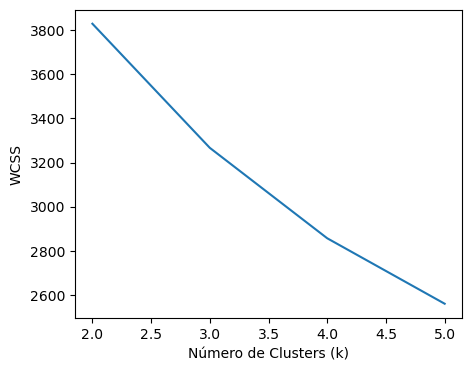

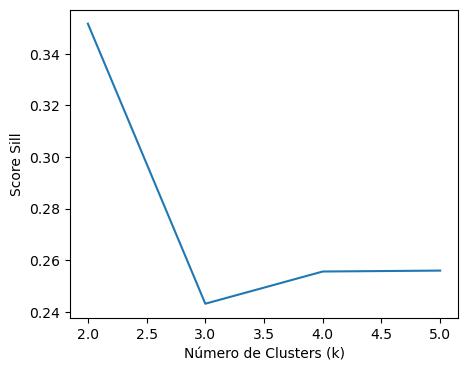

In [12]:
#Testaremos de 2 a 5 clusters

K = np.arange(2,6,1)
wcss = []
sil_score = []

for k in K:
  kmeans = KMeans(n_clusters = k, random_state = 42)
  kmeans.fit(df_scaled)
  wcss.append(kmeans.inertia_)
  score = silhouette_score(df_scaled, kmeans.labels_)
  sil_score.append(score)


plt.figure(figsize = (5,4))
plt.plot(K,wcss)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS')

plt.figure(figsize = (5,4))
plt.plot(K,sil_score)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Score Sill')

- Baseando-se nos gráficos, escolhemos o K em que tenha simultaneamente um alto Score Sill e um baixo WCSS
- k = 4

In [13]:
kmeans_end = KMeans(n_clusters = 4, random_state = 42)
kmeans_end.fit(df_scaled)
clusters_kmeans = kmeans.labels_

df_kmeans_clusters = df.copy()
df_kmeans_clusters["cluster"] = clusters_kmeans

In [14]:
df_kmeans_clusters.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,cluster
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0,3
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6,4
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7,2
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4,2
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2,2


- O dataset acima passaria então pelas etapas para construção de 4 modelos de regressão linear.

In [15]:
df_kmeans_clusters.to_csv("dataset_clusters.csv")

### Criação do modelo sem estratégia de clusters para comparação

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import itertools
from sklearn.model_selection import train_test_split

In [45]:
df = pd.read_csv("boston_2.csv")
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### Avaliação de outliers: 

Ao avaliar a distribuição das variáveis, é possível observar que o CRIM,ZN apresentam curtose e assimetria elevada por apresentar zero inflacionados.
A primeiro momento não será realizada uma limpeza de outliers nessas variáveis visto que o fato delas serem um valor diferente de zero pode indicar uma informação relevante para previsão do preço das casas.

A variável B deve apresentar a assimetria positiva alta devido a alguns subúrbios dos EUA apresentarem uma população majoritariamente branca, o que pode influenciar no preço das casas na região.

Nas demais variáveis será avaliada a retirada de outliers no treino, caso indique um ruído com elevado alavancagem.

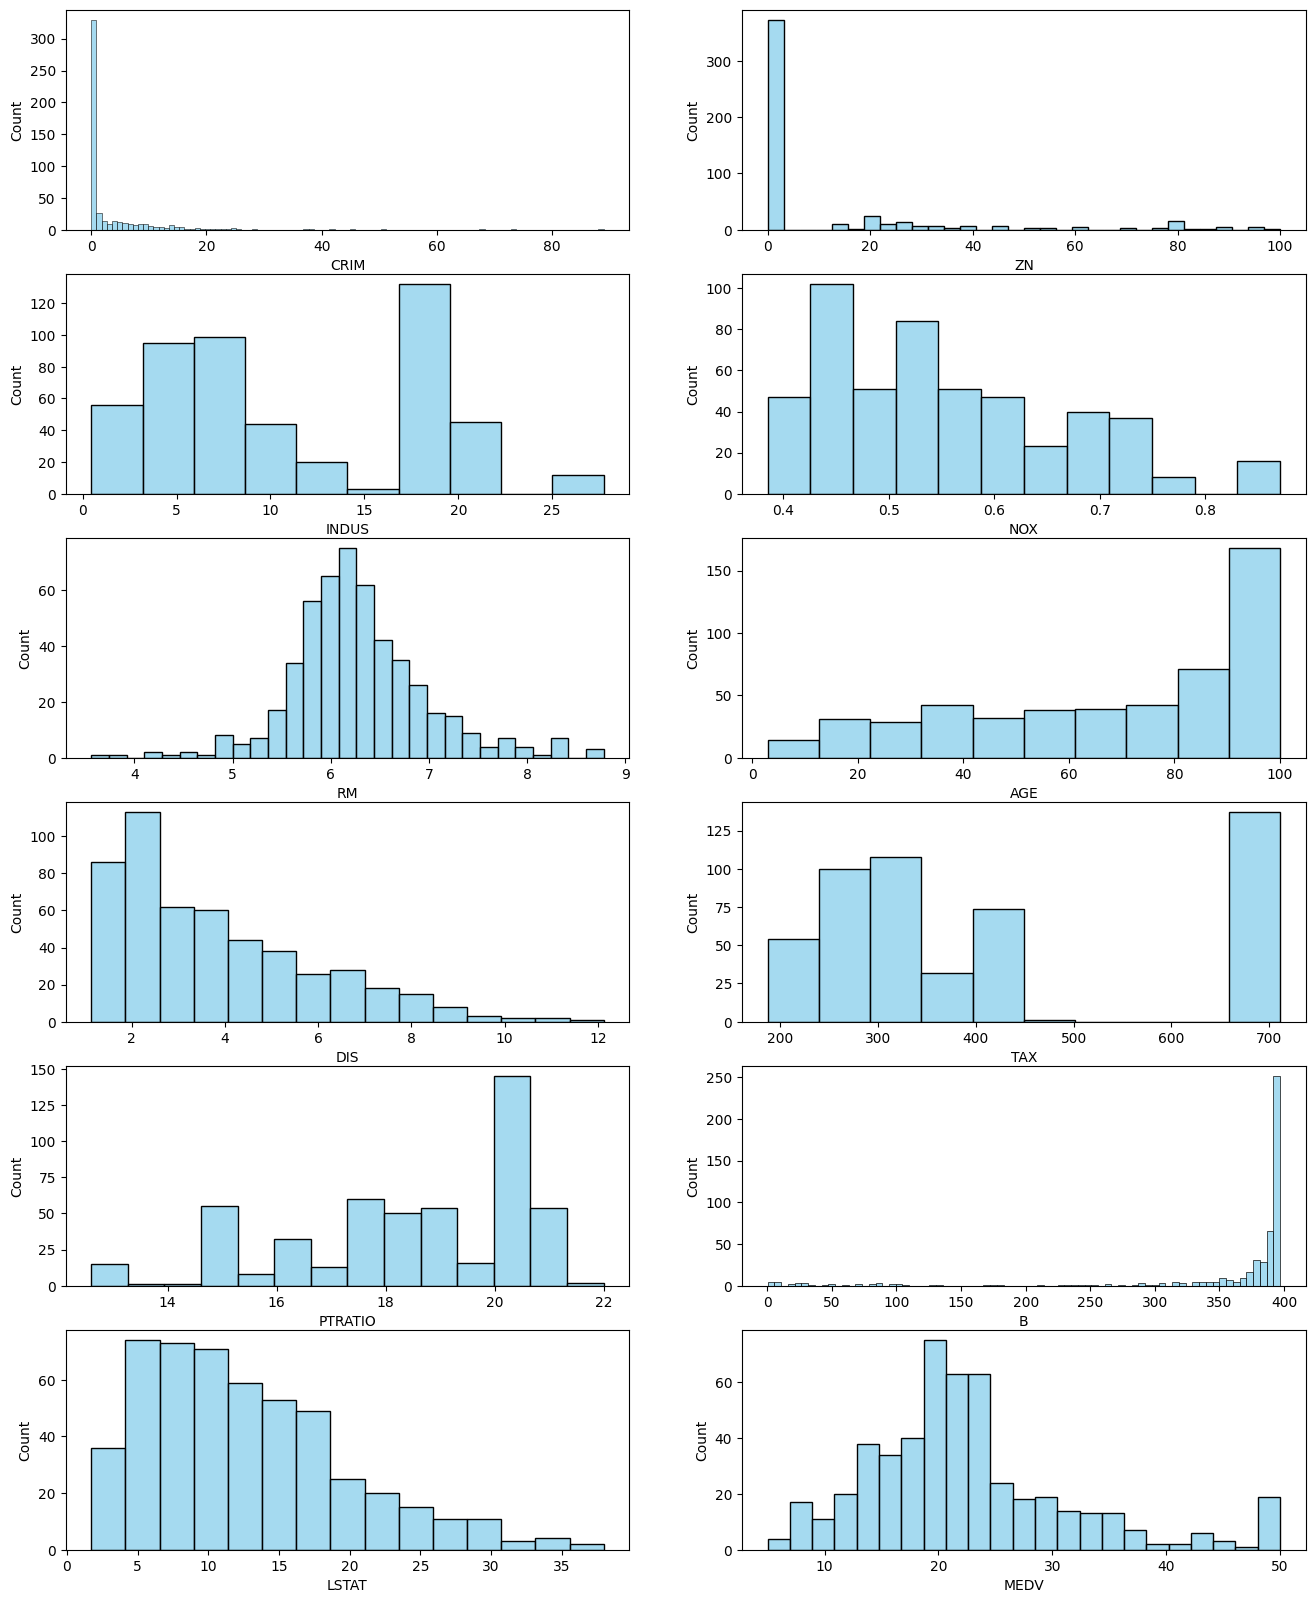

In [46]:
#Continuas 
cont_cols = ['CRIM',
       'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS',
       'TAX', 'PTRATIO','B','LSTAT','MEDV']

fig,axs = plt.subplots(6,2,figsize=(16,20))

axs = axs.ravel()

for i,col in enumerate(cont_cols):

    sns.histplot(df[col],ax=axs[i],color='skyblue')

Nas cidades avaliadas apenas 7% apresentam próximidade ao rio, porém essa proximidade pode indicar situações de luxo. Dessa forma será mantida a variável

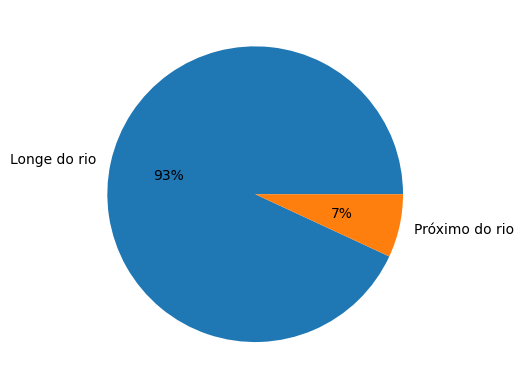

In [47]:
#Categorias

agg = df.groupby(['CHAS']).agg({'LSTAT':'count'}).reset_index()


plt.pie(agg['LSTAT'], labels=['Longe do rio','Próximo do rio'], autopct='%.0f%%') 
  
# displaying chart 
plt.show() 

### Dados redundantes: 

- As variáveis TAX e RAD são as que apresentam correlaçao absoluta elevada (>0.91). Isso ocorre pois o índice de distância das principais rodovias é menor quanto mais próximo de grandes centros, onde a taxa de imposto é maior. Logo, é possível retirar uma das duas informações.


Text(0.5, 1.0, 'Correlação de pearson')

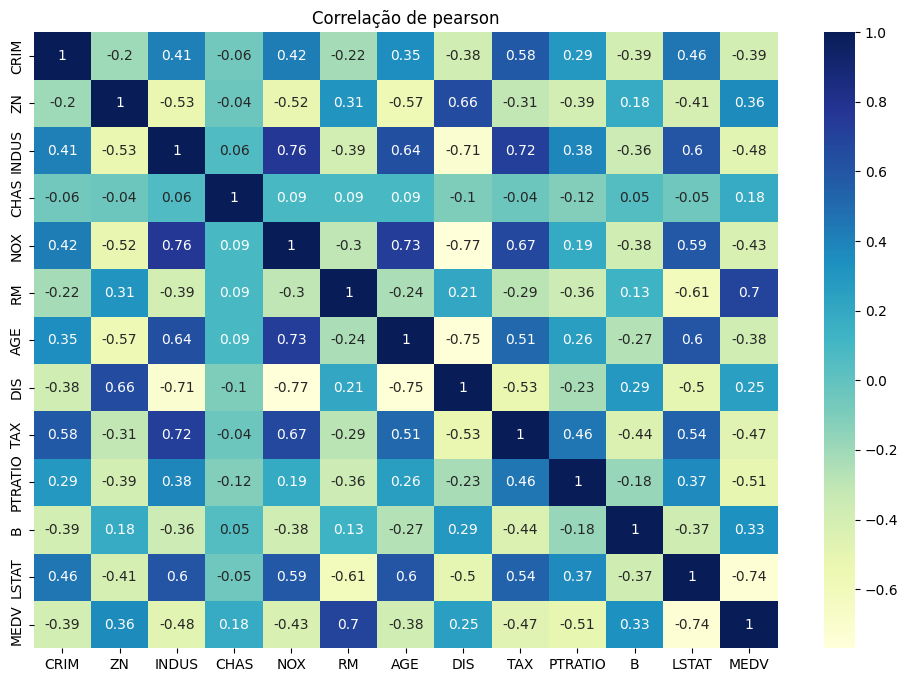

In [234]:
# Plotting correlation heatmap
fig,axs  = plt.subplots(1,1,figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True).round(2), cmap="YlGnBu",annot=True,ax=axs)
plt.title('Correlação de pearson')

In [49]:
df = df.drop(['RAD'],axis=1)

### Criação do modelo 

Etapas:

1. Separação entre treino e teste
1. Normalização dos dados 
2. Identificação de observações de alta alavancagem
3. Escolha dos algoritmos
4. Validação cruzada e otimização de parâmetros
5. Resultado final e conclusões

#### Separação entre treino e teste na proporção com 1/3 da base para teste

In [61]:

train_index,test_index = train_test_split(df.index, test_size=0.33333, random_state=42)

train = df.loc[train_index].reset_index(drop=True)
test = df.loc[test_index].reset_index(drop=True)

#### Normalização dos dados 

In [62]:
scaler = StandardScaler()

cols_norm = [x for x in df.columns if x!='CHAS']

train[cols_norm] = scaler.fit_transform(train[cols_norm])

test[cols_norm] = scaler.transform(test[cols_norm])

#### Observações de alta alavancagem

In [63]:
cols_train = [x for x in df.columns if x!='MEDV']

target = 'MEDV'

m = sm.OLS(train[target],train[cols_train]).fit() 

infl = m.get_influence()

cooks = infl.cooks_distance

train['cooks_d'] = cooks[0]

train['cooks_d'] = cooks[0]

Text(0.5, 0, 'Instância')

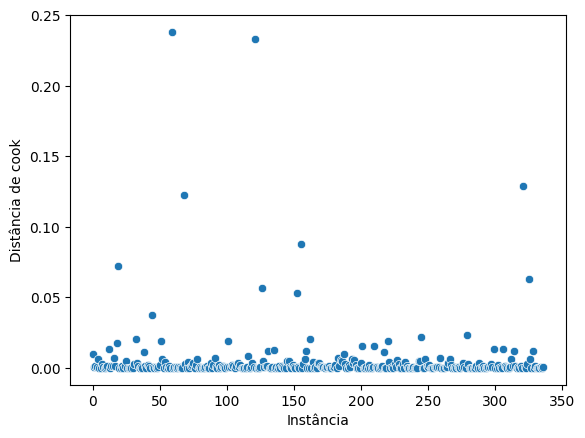

In [64]:
b = sns.scatterplot(x=train.index , y= cooks[0])
plt.ylabel('Distância de cook')
plt.xlabel('Instância')

Avaliando as 5 maiores distâncias, observa-se a primeira cidade apresentar poucos quartos por propriedade (-2 desvios frente a média) e mesmo assim ter um valor médio mais alto, o que pode ser justificado pelo menor % da população com baixo salário, porém como ambas as variáveis, quartos e baixo salário também apresentavam uma correlação razoável (0.7), são observações de cidades específicas.

Como medida serão retirados os 2 primeiros pontos onde apresenta essa discordância.

As variações dos outros 3, parte deve-se a variáveis de proximadade do rio, visto que ela tem pouca incidência, mas será mantida a primeira momento

In [65]:
train.sort_values(by='cooks_d',ascending=False).head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV,cooks_d
59,0.202764,-0.512511,0.983154,0,0.624824,-1.884737,1.117382,-1.133573,1.55126,0.870935,0.193943,-1.282580,2.871164,0.238257
121,11.135418,-0.512511,0.983154,0,0.964347,0.885644,0.827345,-1.094419,1.55126,0.870935,0.434929,0.659177,-1.342145,0.233424
321,0.640839,-0.512511,0.983154,1,0.938883,-0.629885,0.744988,-1.228147,1.55126,0.870935,-0.117603,-0.500310,2.871164,0.129134
68,0.017609,-0.512511,0.983154,1,1.363287,3.398123,0.505081,-0.866862,1.55126,0.870935,-0.042422,-1.000016,-0.118583,0.122615
155,1.324140,-0.512511,0.983154,0,0.624824,-3.419679,1.117382,-1.050558,1.55126,0.870935,-2.557444,0.119104,0.009093,0.087838


In [66]:
train = train[train['cooks_d']<0.2].reset_index(drop=True)

train = train.drop(['cooks_d'],axis=1)

#### Algoritmos e validação cruzada

A validação cruzada é uma técnica essencial para avaliar o desempenho de modelos de aprendizado de máquina de forma robusta e confiável. Ela permite comparar modelos de maneira justa ao reduzir a influência de divisões específicas dos dados nos resultados.

O método mais comum, a validação cruzada k-fold, divide o conjunto de dados em \(k\) subconjuntos (folds). Cada fold é usado como conjunto de teste uma vez, enquanto os demais servem como conjunto de treino. Ao final, a média das métricas obtidas em cada iteração fornece uma estimativa mais estável e generalizável do desempenho do modelo.

**Vantagens da validação cruzada:**
1. **Reduz a variabilidade**: Mitiga o impacto de uma divisão desfavorável dos dados de treino e teste.
2. **Aumenta a confiança na comparação**: Fornece uma métrica mais representativa para comparar modelos, minimizando vieses.
3. **Identifica overfitting**: Ajuda a detectar quando um modelo se ajusta excessivamente aos dados de treinamento e não generaliza bem.

Na comparação entre modelos, a validação cruzada assegura que os resultados obtidos são consistentes e refletem melhor a performance esperada em novos dados.

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge as LR
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import ExtraTreesRegressor as ET
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.model_selection import LeaveOneOut


Parâmetros treino

In [105]:
K = 10

features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX',
       'PTRATIO', 'B', 'LSTAT']

Xtr1 = train[features]
ytr1 = train['MEDV']


model_dict={


            'LR':{
                    # 'solver':['saga'],
                  'alpha':[0.01,0.1,1,10,20,50,80,100],
                  "features":[features]
                  
                  
                  },

            'KNN':{
                    # 'solver':['saga'],
                  'n_neighbors':[5,7,10,14,15,30],
                  'weights':['uniform','distance'],
                  'p':[1,2,3,100],
                  "features":[features]
                  
                  
                  },

            'SVR':{'C':[0.001,0.01,0.1,1,10,50],
                'kernel':['linear','poly','rbf'],
                   "features":[features]
                }
                   ,

            'RF':{'min_samples_split':[5,10,20,30,50],
                  'min_samples_leaf':[5,10,20,30,50],
                  'min_weight_fraction_leaf':[0,0.1,0.2,0.4],
                  "features":[features]
                  
                  
                  },


            'ET':{
                'n_estimators':[5,10,20,50,100],
                'min_samples_split':[5,10,20,30,50],
                  'min_samples_leaf':[5,10,20,30,50],
                  'min_weight_fraction_leaf':[0,0.1,0.2,0.4],
                  "features":[features]
                  
                  }

        }


metrics = np.zeros((2,len(Xtr1))) 

In [106]:

final_results = pd.DataFrame()

mse=1000

for model in model_dict.keys():
    
    for p in itertools.product(*model_dict[model].values()):
        
        model_ = eval(model)

        parameters=dict(zip(model_dict[model].keys(),p))

        features2 = parameters['features']
        parameters.pop('features')

        Xtr = Xtr1[features2]
        ytr = ytr1

        # kfold = KFold(n_splits = K ,
        #                     random_state = 47,shuffle=True) 
        
        kfold = LeaveOneOut()

        for i, (f_ind, outf_ind) in enumerate(kfold.split(Xtr, ytr)):

            X_train = Xtr.loc[f_ind].reset_index(drop=True)
            y_train = ytr.loc[f_ind].reset_index(drop=True)

            X_val = Xtr.loc[outf_ind].reset_index(drop=True)
            y_val = ytr.loc[outf_ind].reset_index(drop=True)
            
            clf = model_(**parameters)

            clf.fit(X_train,y_train.values.ravel())

            lr_probs = clf.predict(X_val)

            lr_probs_t = clf.predict(X_train)
            
            metrics[0,i] = mean_squared_error(y_val,lr_probs)

            metrics[1,i] = mean_squared_error(y_train,lr_probs_t)

        means = metrics.mean(1)
        deviation = metrics.std(1,ddof=1)

        if means[0] < mse:
            mse = means[0]
            print(mse)

        results=pd.DataFrame([{
                            'Model':model,
                            'parameters':parameters,
                            'mse_val':means[0],
                            'mse_val_std':deviation[0],
                            'mse_train':means[1]
                            }])

        final_results=pd.concat([final_results,results],ignore_index=True)


0.2673754743198046
0.2673345578394861
0.2669622489221267
0.2654743612829095
0.18960460789205225
0.162455642046892
0.1451572307543554
0.09299006223243686


Selecionar modelo com menor erro médio quadrático.

In [108]:
final_results.sort_values('mse_val',ascending=True)


,Model,parameters,mse_val,mse_val_std,mse_train
70,SVR,"{'C': 10, 'kernel': 'rbf'}",0.092990,0.262476,0.029343
73,SVR,"{'C': 50, 'kernel': 'rbf'}",0.110373,0.236648,0.015648
67,SVR,"{'C': 1, 'kernel': 'rbf'}",0.145157,0.559122,0.093328
174,ET,"{'n_estimators': 5, 'min_samples_split': 5, 'm...",0.159851,0.518873,0.099995
494,ET,"{'n_estimators': 50, 'min_samples_split': 10, ...",0.160480,0.575770,0.087919
...,...,...,...,...,...
201,ET,"{'n_estimators': 5, 'min_samples_split': 10, '...",0.787557,1.651799,0.755202
261,ET,"{'n_estimators': 5, 'min_samples_split': 50, '...",0.789101,1.657394,0.764126
217,ET,"{'n_estimators': 5, 'min_samples_split': 20, '...",0.797861,1.686057,0.759218
57,SVR,"{'C': 0.001, 'kernel': 'poly'}",0.867121,1.814980,0.863736


Ajuste fino do melhor modelo

In [110]:
K = 10

features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX',
       'PTRATIO', 'B', 'LSTAT']

Xtr1 = train[features]
ytr1 = train['MEDV']


model_dict={


            'SVR':{'C':[10,15,20,25,30,35,40],
                   'gamma':['auto','scale',0.0001,0.001,0.01,0.1,1,3,5,10],
                'kernel':['rbf'],
                   "features":[features]
                }
                   ,

        }


metrics = np.zeros((2,len(Xtr1))) 


final_results = pd.DataFrame()

mse=1000

for model in model_dict.keys():
    
    for p in itertools.product(*model_dict[model].values()):
        
        model_ = eval(model)

        parameters=dict(zip(model_dict[model].keys(),p))

        features2 = parameters['features']
        parameters.pop('features')

        Xtr = Xtr1[features2]
        ytr = ytr1

        # kfold = KFold(n_splits = K ,
        #                     random_state = 47,shuffle=True) 
        
        kfold = LeaveOneOut()

        for i, (f_ind, outf_ind) in enumerate(kfold.split(Xtr, ytr)):

            X_train = Xtr.loc[f_ind].reset_index(drop=True)
            y_train = ytr.loc[f_ind].reset_index(drop=True)

            X_val = Xtr.loc[outf_ind].reset_index(drop=True)
            y_val = ytr.loc[outf_ind].reset_index(drop=True)
            
            clf = model_(**parameters)

            clf.fit(X_train,y_train.values.ravel())

            lr_probs = clf.predict(X_val)

            lr_probs_t = clf.predict(X_train)
            
            metrics[0,i] = mean_squared_error(y_val,lr_probs)

            metrics[1,i] = mean_squared_error(y_train,lr_probs_t)

        means = metrics.mean(1)
        deviation = metrics.std(1,ddof=1)

        if means[0] < mse:
            mse = means[0]
            print(mse)

        results=pd.DataFrame([{
                            'Model':model,
                            'parameters':parameters,
                            'mse_val':means[0],
                            'mse_val_std':deviation[0],
                            'mse_train':means[1]
                            }])

        final_results=pd.concat([final_results,results],ignore_index=True)

0.09802229162324072
0.09299006223243686
0.09247117464031919
0.09181582389113659


In [111]:
final_results.sort_values('mse_val',ascending=True)

,Model,parameters,mse_val,mse_val_std,mse_train
11,SVR,"{'C': 15, 'gamma': 'scale', 'kernel': 'rbf'}",0.091816,0.251302,0.025834
5,SVR,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.092471,0.261671,0.028002
20,SVR,"{'C': 20, 'gamma': 'auto', 'kernel': 'rbf'}",0.092961,0.252605,0.025561
1,SVR,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.092990,0.262476,0.029343
15,SVR,"{'C': 15, 'gamma': 0.1, 'kernel': 'rbf'}",0.092992,0.245506,0.024571
...,...,...,...,...,...
9,SVR,"{'C': 10, 'gamma': 10, 'kernel': 'rbf'}",0.886106,1.634261,0.009037
59,SVR,"{'C': 35, 'gamma': 10, 'kernel': 'rbf'}",0.886106,1.634261,0.009037
39,SVR,"{'C': 25, 'gamma': 10, 'kernel': 'rbf'}",0.886106,1.634261,0.009037
19,SVR,"{'C': 15, 'gamma': 10, 'kernel': 'rbf'}",0.886106,1.634261,0.009037


Modelo final e avaliação

In [136]:
clf = SVR(C=15,gamma='scale',kernel='rbf')

clf.fit(Xtr1,ytr1.values.ravel())

test['PRED'] = clf.predict(test[features])

Avaliar se o erro segue uma distribuição normal, garantindo que os desvios entre o predito e real não apresentem algum viés

Erro médio quadrado:0.15392


<Axes: ylabel='Count'>

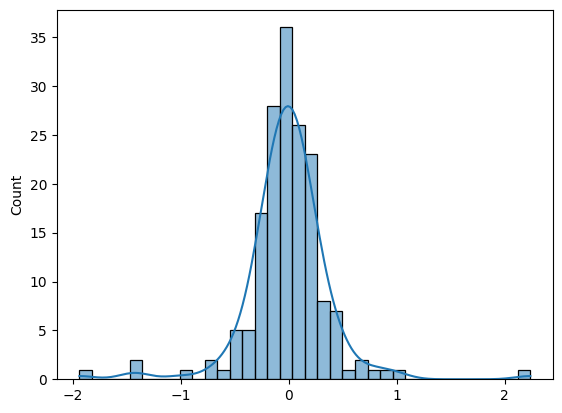

In [137]:
import scipy.stats as stats

erro_mse = mean_squared_error(test['MEDV'],test['PRED']).round(5)

print(f'Erro médio quadrado:{erro_mse}')

error = test['MEDV'] - test['PRED']

sns.histplot(error,kde=True)

Gráfico de quantil frente a normal para verificar ajuste. Observa-se 3 pontos que desviam da distribuição, com uma variável CRIM com desvio padrão em 3 deles maior que 5 desvios.

Será realizada uma seleção de variáveis testando todas as combinações para manter o conjunto de variáveis que otimize o resultado, além de limitar todos os valores acima de 4 desvios padrões para variável CRIM

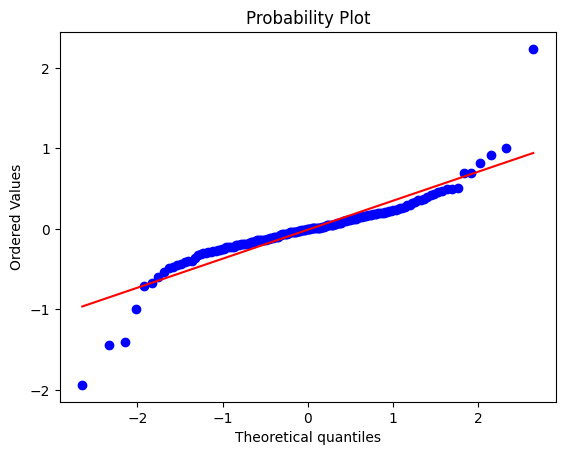

In [138]:
a = stats.probplot(error,dist='norm',plot=plt)

In [140]:
train['CRIM'] = np.where(train['CRIM']>4,4,train['CRIM'])
test['CRIM'] = np.where(test['CRIM']>4,4,test['CRIM'])

Xtr1 = train[features]
ytr1 = train['MEDV']

In [ ]:
from joblib import Parallel, delayed
from scipy.stats import ttest_ind
from itertools import chain, combinations,islice
from sklearn.model_selection import cross_val_score
import gc

def evaluate_and_update(features):

    global best_features, best_scores_distribution, Xtr1, ytr1

    X_subset = Xtr1[list(features)]

    cv = LeaveOneOut()

    clf = SVR(C=15,gamma='scale',kernel='rbf')
    scores = cross_val_score(clf, X_subset, ytr1.to_numpy(),scoring='neg_mean_squared_error',cv=cv,n_jobs=1)

    score_mean = np.mean(scores)

    best_scores_distribution.append(scores)
    best_features.append(features)

    del clf
    gc.collect()

    return best_scores_distribution,best_features


In [ ]:
features = Xtr1.columns
all_combinations = chain.from_iterable(combinations(features, r) for r in range(1, len(features)+1))

best_score = 0
best_features = []
best_scores_distribution = [] 
#process_in_blocks(all_combinations, block_size=1000)
results = Parallel(n_jobs=6)(delayed(evaluate_and_update)(feature_set) for feature_set in all_combinations)


K = len(Xtr)
# Concatenar os resultados de cada processo na lista final
i = 0
for  scores,features in results:
    
    if i == 0:

        best_features = features[0]
        best_score = np.mean(scores)
        best_score_dist = scores

    else:

        p_value = ttest_ind(best_score_dist[0], scores[0]).pvalue

        score_mean = np.mean(scores)

        alpha_adjust = p_value/K

        if (alpha_adjust < 0.05 and score_mean > best_score)  or (len(best_features)>len(features[0]) and alpha_adjust > 0.05):

            best_features = features[0]
            best_score = score_mean
            best_score_dist = scores

            print(best_score)
            print(best_features)


    i+=1


-0.7634229388181556
('INDUS',)
-0.41217765727563754
('RM',)
-0.31153509256267825
('LSTAT',)
-0.28217197184342147
('CRIM', 'LSTAT')
-0.24745117194190727
('RM', 'LSTAT')
-0.18595209809079608
('CRIM', 'RM', 'LSTAT')
-0.17046723435157937
('RM', 'TAX', 'LSTAT')
-0.16642073372148838
('CRIM', 'INDUS', 'RM', 'LSTAT')
-0.15076146190855216
('CRIM', 'NOX', 'RM', 'LSTAT')
-0.14317858313395015
('CRIM', 'RM', 'TAX', 'LSTAT')
-0.142613387016381
('CRIM', 'INDUS', 'RM', 'DIS', 'LSTAT')
-0.13747111782500165
('CRIM', 'CHAS', 'RM', 'PTRATIO', 'LSTAT')
-0.13207937076703535
('CRIM', 'NOX', 'RM', 'TAX', 'LSTAT')
-0.12800630184223868
('CRIM', 'RM', 'AGE', 'TAX', 'LSTAT')
-0.12282929059279726
('RM', 'AGE', 'TAX', 'B', 'LSTAT')
-0.11566977369745444
('CRIM', 'INDUS', 'RM', 'AGE', 'TAX', 'LSTAT')
-0.11109287798674382
('RM', 'AGE', 'DIS', 'TAX', 'B', 'LSTAT')
-0.10932531654663057
('RM', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT')
-0.10558826998642654
('CRIM', 'RM', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT')
-0.104197633038

O erro médio reduziu no teste de 0.15 para 0.11 com o ajuste de seleção de variáveis. Os valores em que era superestimado o valor da propriedade já não ocorrem mais com o ajuste. No entanto agora, o modelo tem uma tendência a subestimar os valores da casa (observado na assemetria deslocada a esquerda no histograma do erro), mesmo que com pouca incidência (quatro observações tiveram um desvio relevante frente a uma distribuição normal)

In [197]:
features_sel = ['CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']

clf = SVR(C=15,gamma='scale',kernel='rbf')

clf.fit(Xtr1[features_sel],ytr1.values.ravel())

test['PRED'] = clf.predict(test[features_sel])

Erro médio quadrado:0.10782


<Axes: ylabel='Count'>

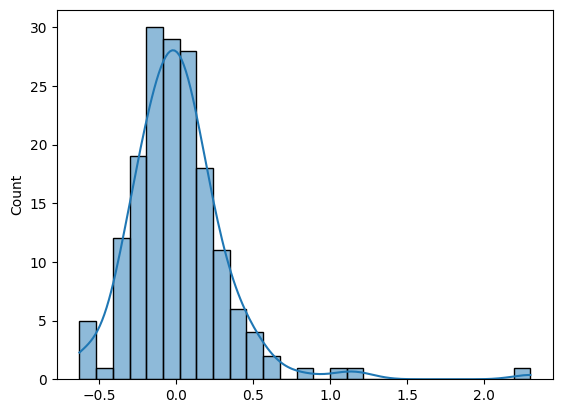

In [198]:
erro_mse = mean_squared_error(test['MEDV'],test['PRED']).round(5)

print(f'Erro médio quadrado:{erro_mse}')

error = test['MEDV'] - test['PRED']

sns.histplot(error,kde=True)

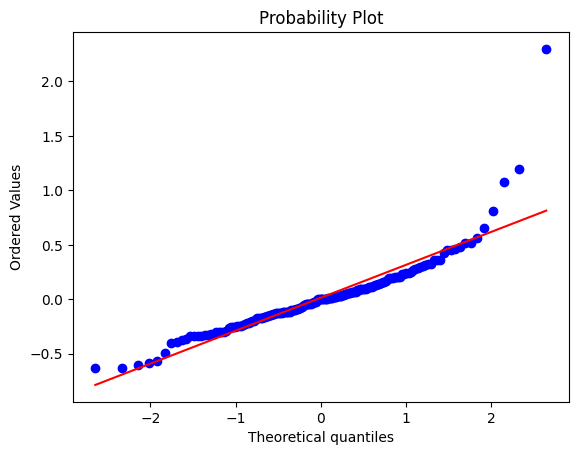

In [200]:
a = stats.probplot(error,dist='norm',plot=plt)

Convertendo o erro normalizado para o real, o modelo apresenta um erro médio de $3000. Retirando os erros extremos de pouca incidência, o erro na predição do valor das casas é de $1000.

Erro médio em $/1000 com outliers: 3.0861967384652615
Erro médio em $/1000 sem outliers: 1.0155151737814292


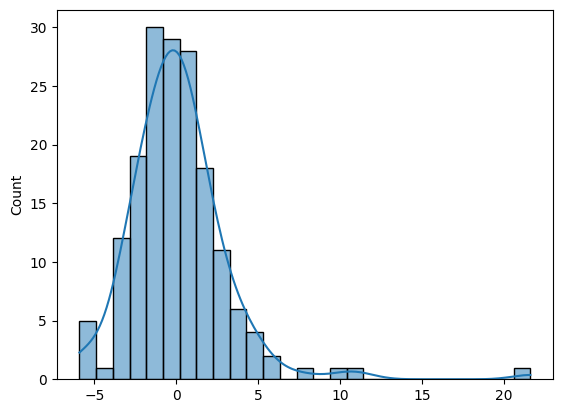

In [252]:
test['Valor_medio_res_pred'] = (test['PRED']*scaler.scale_[-1]) + scaler.mean_[-1]
test['Valor_medio_real'] = (test['MEDV']*scaler.scale_[-1]) + scaler.mean_[-1]

error = mean_squared_error(test['Valor_medio_real'],test['Valor_medio_res_pred'])**0.5

print(f'Erro médio em $/1000 com outliers: {error}')

erro_real = test['Valor_medio_real'] - test['Valor_medio_res_pred']

sns.histplot(erro_real,kde=True)

print(f'Erro médio em $/1000 sem outliers: {((erro_real[erro_real<10]**2)**0.05).mean()}')


#### Importância das variáveis

Para entender como cada variável impacta o modelo será utilizado o SHAP (SHapley Additive exPlanations).

O SHAP (SHapley Additive exPlanations) é uma técnica baseada na teoria dos valores de Shapley, originada da teoria dos jogos, para interpretar modelos de aprendizado de máquina. Ele atribui uma contribuição de cada variável preditora para a predição de um modelo, permitindo uma compreensão detalhada e transparente do impacto de cada característica no resultado.

A principal vantagem do SHAP é que ele fornece explicações consistentes e globalmente interpretáveis, mesmo para modelos complexos e não lineares. Ele calcula os **valores SHAP**, que representam a diferença entre a previsão feita pelo modelo e a média das predições, considerando as combinações de todas as variáveis possíveis.

In [204]:
import shap

explainer = shap.KernelExplainer(clf.predict, test[features_sel])
shap_values = explainer.shap_values(test[features_sel])

Using 169 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/169 [00:00<?, ?it/s]

Com o shap, conclui-se que tanto a quantidade de quartos médio (RM), quanto o % da cidade com baixa renda (LSTAT) são os que mais contribuem no modelo, com o primeiro com uma corrlação positiva e o segundo negativa. O resultado do SHAP para essas duas variáveis é parecido com o observado na correlação de pearson, sendo essas duas com maior correlação.

Outras análises fatores como residências mais novas e proximidade a centros comerciais também contribuem para a valorizaçào. Por fim, uma menor concentração de óxidos de nitrogênio no ar indicam uma valorização, sendo um indicador de menor poluição na região.

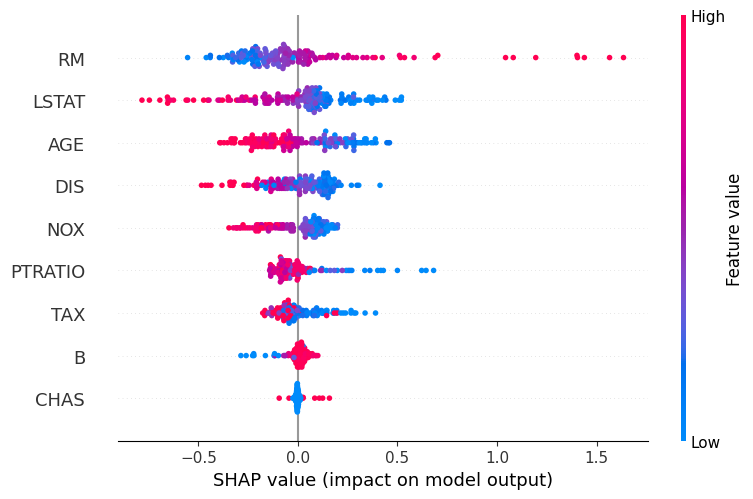

In [205]:
shap.summary_plot(shap_values, test[features_sel], feature_names=features_sel)

Abaixo é apresentado dois exemplos do quanto cada variável contribue para a predição final. A soma da contribuição de cada variável no shap, resulta na predição final, podendo ser utilizada para avaliar o que mais contribuiu para decisão do modelo naquela observação.

Nos dois exemplos abaixo, são os extremos de maior e menor valor predito no modelo, respectivamente. A primeira a média de quartos é o que mais puxou o preço da médio da região para cima. Por outro lado, na de menor valor, a proporção de da população de baixo salário, como a média de quartos e a concetração de óxidos de nitrogênio, contribuíram para um menor valor médio.

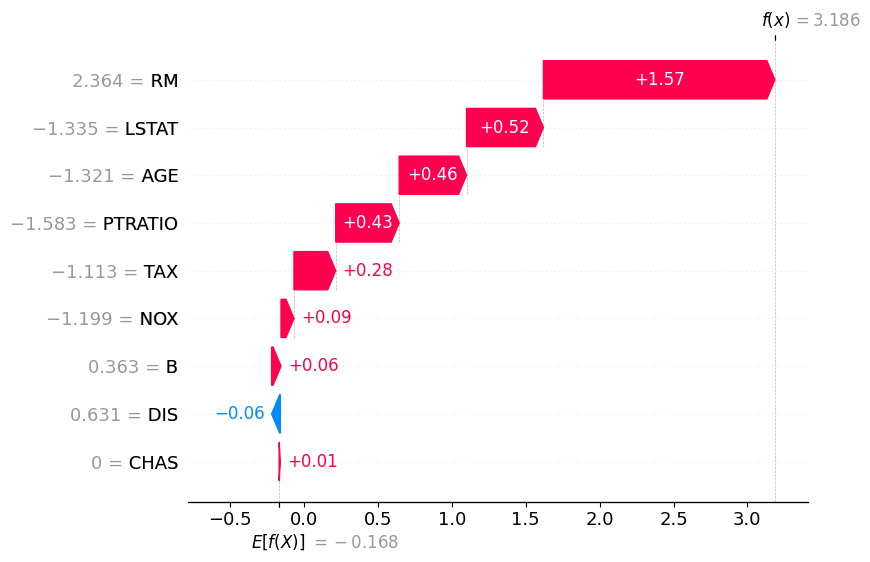

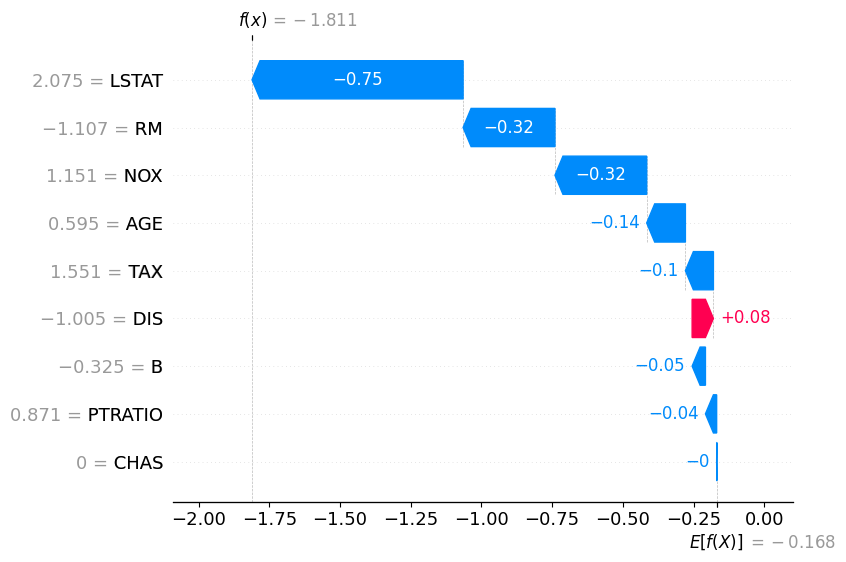

In [ ]:
shap.waterfall_plot(shap.Explanation(values=shap_values[42], 
                                     base_values=explainer.expected_value, 
                                     data=test[features_sel].iloc[42], 
                                     feature_names=features_sel))

shap.waterfall_plot(shap.Explanation(values=shap_values[144], 
                                     base_values=explainer.expected_value, 
                                     data=test[features_sel].iloc[144], 
                                     feature_names=features_sel))
